#Step 1: Mount Google Drive

In [17]:
from google.colab import drive
drive.mount('/content/drive')


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


#Step 2: Define and check Dataset Paths
#dataset is located in the AUDIO folder, with subfolders REAL and FAKE

In [ ]:
import os

DATASET_PATH = "/content/drive/MyDrive/AUDIO"

real_path = os.path.join(DATASET_PATH, "REAL")
fake_path = os.path.join(DATASET_PATH, "FAKE")

print(f"Real samples: {len(os.listdir(real_path))}")
print(f"Fake samples: {len(os.listdir(fake_path))}")


Real samples: 8
Fake samples: 56


#Step 3: Install Required Libraries
#torchaudio, librosa, numpy, matplotlib

In [ ]:
!pip install torchaudio librosa


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 78.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 55.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 44.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 5.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 12.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 7.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 5.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 93.4 MB/s eta 0:00:00
  Attempting uninstall: nvidia-nvjitlink-cu12
    Found existing installation: nvidia-nvjitlink-cu12 12.5.82
    Uninstalling nvidia-nvjitlink-cu12-12.5.82:
      Successfully uninstalled nvidia-nvjitlin

#Step 4: Preprocess the Audio Data
#Convert audio files into spectrograms or Mel-frequency cepstral coefficients (MFCCs).

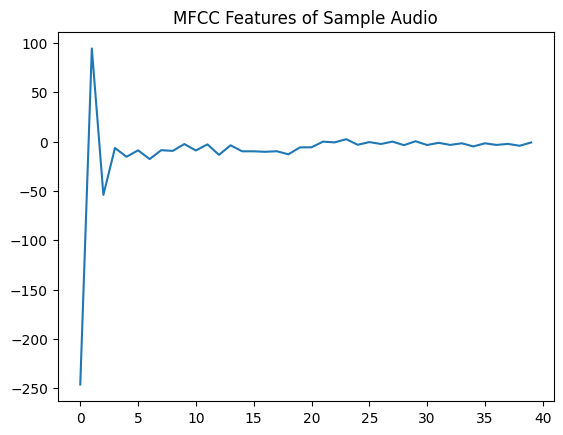

In [ ]:
import librosa
import librosa.display
import numpy as np
import matplotlib.pyplot as plt

def extract_features(file_path):
    y, sr = librosa.load(file_path, sr=16000)
    mfccs = librosa.feature.mfcc(y=y, sr=sr, n_mfcc=40)
    return np.mean(mfccs.T, axis=0)  # Taking mean across time axis

# Example
sample_file = os.path.join(real_path, os.listdir(real_path)[0])
features = extract_features(sample_file)

plt.plot(features)
plt.title("MFCC Features of Sample Audio")
plt.show()


#Step 5: Create Dataset for Training

In [ ]:
import torch
from torch.utils.data import Dataset, DataLoader

class AudioDataset(Dataset):
    def __init__(self, data_path, label):
        self.files = [os.path.join(data_path, f) for f in os.listdir(data_path) if f.endswith('.wav')]
        self.label = label

    def __len__(self):
        return len(self.files)

    def __getitem__(self, idx):
        file_path = self.files[idx]
        features = extract_features(file_path)
        return torch.tensor(features, dtype=torch.float32), torch.tensor(self.label, dtype=torch.long)

# Load datasets
real_dataset = AudioDataset(real_path, label=0)  # Real label: 0
fake_dataset = AudioDataset(fake_path, label=1)  # Fake label: 1

# Combine datasets
full_dataset = real_dataset + fake_dataset
train_loader = DataLoader(full_dataset, batch_size=16, shuffle=True)

# Test data loading
for x, y in train_loader:
    print("Batch Features:", x.shape)
    print("Batch Labels:", y)
    break


Batch Features: torch.Size([16, 40])
Batch Labels: tensor([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1])


#Step 6: Define a Deep Learning Model(neural network)

In [ ]:
import torch.nn as nn
import torch.optim as optim

class AudioClassifier(nn.Module):
    def __init__(self):
        super(AudioClassifier, self).__init__()
        self.fc1 = nn.Linear(40, 64)
        self.fc2 = nn.Linear(64, 32)
        self.fc3 = nn.Linear(32, 2)  # Output: 2 classes (Real, Fake)
        self.relu = nn.ReLU()
        self.softmax = nn.Softmax(dim=1)

    def forward(self, x):
        x = self.relu(self.fc1(x))
        x = self.relu(self.fc2(x))
        x = self.softmax(self.fc3(x))
        return x

# Initialize model
model = AudioClassifier()
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)


#Step 7: Train the Model

In [ ]:
epochs = 10
for epoch in range(epochs):
    total_loss = 0
    for inputs, labels in train_loader:
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()

    print(f"Epoch {epoch+1}, Loss: {total_loss/len(train_loader)}")


Epoch 1, Loss: 0.43874814361333847
Epoch 2, Loss: 0.43827804923057556
Epoch 3, Loss: 0.4382633939385414
Epoch 4, Loss: 0.43826210498809814
Epoch 5, Loss: 0.43826187402009964
Epoch 6, Loss: 0.4382617473602295
Epoch 7, Loss: 0.4382617622613907
Epoch 8, Loss: 0.4382617250084877
Epoch 9, Loss: 0.4382617250084877
Epoch 10, Loss: 0.4382616952061653


#Step 8: Save the Model

In [9]:
torch.save(model.state_dict(), "/content/drive/MyDrive/audio_classifier.pth")
print("Model saved successfully!")


Model saved successfully!


#Step 9: Load the Saved Model

#reload the trained model from Google Drive

In [10]:


model_path = "/content/drive/MyDrive/audio_classifier.pth"

# Initialize model
model = AudioClassifier()
model.load_state_dict(torch.load(model_path))
model.eval()  # Set model to evaluation mode

print("Model loaded successfully!")


Model loaded successfully!


#Step 10: Prepare a Test Audio File
#Choose an audio file from the dataset or upload a new one.
#Use an Existing File

In [11]:
test_file = os.path.join(fake_path, os.listdir(fake_path)[0])  # Test with a FAKE sample
print(f"Testing with: {test_file}")


Testing with: /content/drive/MyDrive/AUDIO/FAKE/Obama-to-Biden.wav


#Step 11: Extract Features from the Test File
#Use the same feature extraction function as before.

In [12]:
test_features = extract_features(test_file)
test_tensor = torch.tensor(test_features, dtype=torch.float32).unsqueeze(0)  # Add batch dimension


#Step 12: Make a Prediction
#Pass the extracted features through the model to get predictions.

In [13]:
with torch.no_grad():
    output = model(test_tensor)
    predicted_label = torch.argmax(output, dim=1).item()

# Interpret the result
label_map = {0: "REAL", 1: "FAKE"}
print(f"Predicted Label: {label_map[predicted_label]}")


Predicted Label: REAL


#Step 13: Display Model Confidence
#You can also view the confidence scores.

In [14]:
probabilities = torch.softmax(output, dim=1).numpy()[0]
print(f"Confidence Scores: REAL={probabilities[0]:.4f}, FAKE={probabilities[1]:.4f}")


Confidence Scores: REAL=0.7310, FAKE=0.2690
